# Learning to think like a JAX vmap

In [33]:
import jax.numpy as jnp
from jax import vmap, random, jit
import matplotlib.pyplot as plt
from jax.image import resize

To help you structure your JAX code to be vmap friendly, start with the outcome you are trying to achieve.

In this case I am going to start with an empty mosaic. I am going to then try to fill the mosaic using a vmap.

In [34]:
rows, cols = (10,10)
width, height = (100,100)
empty_mosaic = jnp.zeros((rows * height, cols * width))

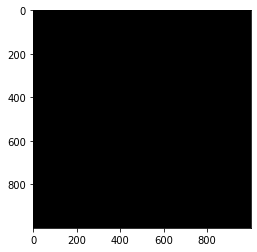

In [35]:
plt.imshow(empty_mosaic, vmax=1, vmin=0,  cmap='gray')
plt.show()

Vmap only vectorizes along a single axis. This monochrome image has 2 axes. You can nest vmaps, but the code is quite messy. To really think like vmap, if you want to process each pixel in the image, transform the array onto a single axis. You can transform it back whenever you want to show it as an image.

In [36]:
flat_mosaic = jnp.ravel(empty_mosaic)
flat_mosaic.shape

(1000000,)

Use reshape to turn the flat array back into a 2D image.

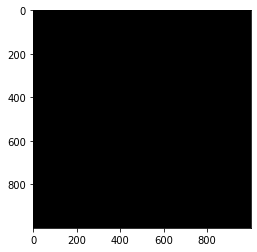

In [37]:
plt.imshow(jnp.reshape(flat_mosaic, empty_mosaic.shape),vmax=1, vmin=0,  cmap='gray')
plt.show()

Now lets get to work filling in the contents of our flattened mosaic using a dummy vmap. The dummy function returns a constant value so we get a 50% grey image.

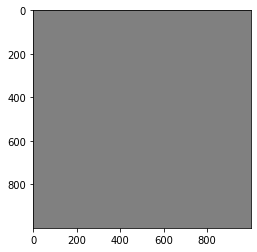

In [38]:
@jit
def transform(pixel):
    return 0.5

mosaic_1 = vmap(transform)(flat_mosaic)
plt.imshow(jnp.reshape(mosaic_1, empty_mosaic.shape), vmax=1, vmin=0,  cmap='gray')
plt.show()

Of course this isn't yet a mosaic, but we are going to do this bit by bit. All we have so far is a vectorizable function that transforms a pixel. Next we will introduce some randomness in that transformation.

To do that I am going to need to send random keys to my transform function. I will need a unique key for each element. As long as my keys are an array with the same axis as my flat image, JAX will cycle through the elements of the keys array in sync with the elements of the pixels array, so the transform function below will operate on scalar elements: pixel and key.

Note: I got into the habit of naming my arguments using names that describe logically what the function is expecting to operate on: a single *pixel* and a single *key*. This helps me remember what each vmapped function is supposed to be operating on, so if I make a mistake and it operates on something else, the mistake is clearer to me. In my ChopShop library I took this a step further. I have custom types for things like RGB images, images slices, channels, pixels etc. I use these custom types as type hints.

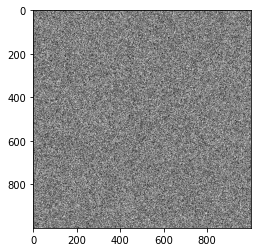

In [45]:
key = random.PRNGKey(29)
key, gen_key = random.split(key)
keys = random.split(gen_key, flat_mosaic.shape[0])
keys = jnp.array(keys)

@jit
def transform(pixel,key):
    return random.bernoulli(key,0.5,(1,))

mosaic_1 = vmap(transform)(flat_mosaic, keys).block_until_ready()
plt.imshow(jnp.reshape(mosaic_1, empty_mosaic.shape), vmax=1, vmin=0,  cmap='gray');

This is still not a mosaic. We are looking to see a 10X10 grid. Inside each cell of this grid, we want a different greyscale value. At the moment the whole image has a random greyscale value of 0.5.

We will build a thumbnail to describe the desired brightness of each cell in the grid.

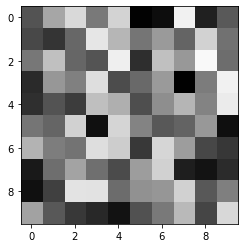

In [46]:
key, t_key = random.split(key)
thumbnail = random.uniform(t_key,minval=0,maxval=1, shape = (cols,rows))
plt.imshow(thumbnail, vmax=1, vmin=0,  cmap='gray');

How do we superimpose the brightness features of this 10X10 grid on a 1000 x 1000 image to turn it into a mosaic? To avoid looping and stick with what jax does so well - vmap - we need to get vmap to understand this thumbnail. Our vmapped transform function is operating on a 1M element flat array...so the answer is actually quite obvious. We need to turn this 10X10 array into 1M element flat array so that vmap can process it.

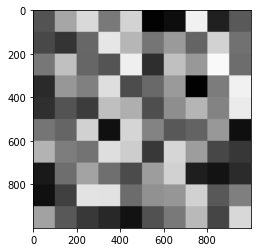

In [48]:
thumb = resize(thumbnail,method='nearest', shape = empty_mosaic.shape)
plt.imshow(thumb, vmax=1, vmin=0,  cmap='gray');

We are half way there. I have the right number of elements in my thumbnail array. Now I just need to flatten it.

In [49]:
flat_thumb = jnp.ravel(thumb)
flat_thumb.shape

(1000000,)

This flattened enlarged thumbnail image contains the features of the 10X10 image expanded into a vmap ready form. We just need to modify the transform function to use it. We do this by adding a new "brightness" argument and driving the probability value of our random number generator from the desired brightness of each pixel.

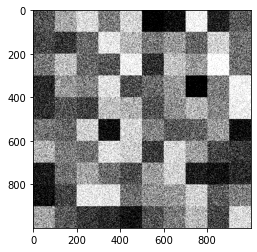

In [50]:
@jit
def transform(pixel,key,brightness):
    return random.bernoulli(key,brightness,(1,))

mosaic_1 = vmap(transform)(flat_mosaic,keys,flat_thumb)
plt.imshow(jnp.reshape(mosaic_1, empty_mosaic.shape), vmax=1, vmin=0,  cmap='gray');

Admittedly the mosaic above is no Mona Lisa, but all that is missing is a better thumbnail and a better transform function and the Mona Lisa is within reach. The structure is in place for producing a mosaic using monte carlo methods based on features derived from a thumbnail.

## Conclusions

1. The array contortions above may seem strange.
2. Perhaps they are strange, but they are simple, perform well and are debuggable. My previous miss-adventures with working imperatively building up the mosaic one slice at a time may have been more intuitive, but it was a lot more complex and slow. It also turned out to be close to impossible for me as a noob to troubleshoot.
3. If you find yourself wrestling with JAX like I did, I urge you to work backwards from your desired output. Transform that desired output into a form where you can execute a vectorized function over a single axis. Then transform all of the inputs so that they have the same shape as this common axis for vectorization. As long as you can do this, there is no need for wrestling. You can process the inputs element-wise inside the function that you vmap.

Note: There is no need to transform scalar inputs or any other arrays that are going to act as constant values inside your vmapped function. You can use the "in_axes" vmap argument to designate if and how each input to the vmapped function should be processed.

## Bloopers and Outtakes

It wasn't all plain sailing to reach this point. In this section I will risk being ridiculed by sharing some of the things I did wrong along the way.

### Getting used to PRNG

You need to get organised about how you use keys to avoid inadvertently reusing one. This pattern works:


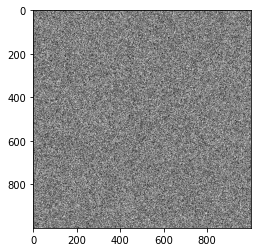

In [30]:
key = random.PRNGKey(29)
key, gen_key = random.split(key)
keys = random.split(gen_key, flat_mosaic.shape[0])
keys = jnp.array(keys)

@jit
def transform(pixel,key):
    return random.bernoulli(key,0.5,(1,))

mosaic_1 = vmap(transform)(flat_mosaic, keys).block_until_ready()
plt.imshow(jnp.reshape(mosaic_1, empty_mosaic.shape), vmax=1, vmin=0,  cmap='gray');

Look what happens if you pass a single key into the vmapped function. Instead of splitting the key into an array of keys, I unpacked the split result into 2 keys.

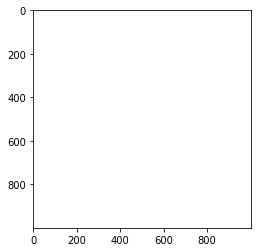

In [31]:
key, gen_key = random.split(key)

@jit
def transform(pixel,key):
    return random.bernoulli(key,0.5,(1,))

mosaic_1 = vmap(transform, in_axes=(0,None))(flat_mosaic, gen_key).block_until_ready()
plt.imshow(jnp.reshape(mosaic_1, empty_mosaic.shape), vmax=1, vmin=0,  cmap='gray');

The transform function with the random number generator is still called for every element of the array, but it returns the same value for each execution because the key is the same.

Here is another key related blooper. The code below works functionally. It involves a bit less code than the pattern that worked well. Instead of building a special key just to generate more keys, I pack a whole lot of keys into the variable named *keys* and then convert *keys* into an array.

This code runs painfully slowly.

In [32]:
key, *keys = random.split(key, flat_mosaic.shape[0]+1)
keys = jnp.array(keys)

@jit
def transform(pixel,key):
    return random.bernoulli(key,0.5,(1,))

def vmap_transform(flat_mosaic, keys):
    return vmap(transform)(flat_mosaic, keys)

jit_f = jit(vmap_transform)
%time jit_f(flat_mosaic,keys)
%timeit mosaic_1 = vmap_transform(flat_mosaic,keys).block_until_ready()

CPU times: total: 1.66 s
Wall time: 1.71 s
16.8 ms ± 727 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The code above takes over a minute to run - not 1.57s. The code below comes back immediately.

In [15]:
fast_keys = random.split(gen_key, flat_mosaic.shape[0])
%time jit_f(flat_mosaic,fast_keys)
%timeit mosaic_1 = vmap_transform(flat_mosaic,fast_keys).block_until_ready()

CPU times: total: 31.2 ms
Wall time: 30 ms
26.4 ms ± 1.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


I still don't know why. I assume that something about how *keys* presents itself to the JIT compiler causes multiple recompiles.

When JAX compiles code that contains arrays, the code is compiled for a fixed array size. If the array sized changes JAX will recompile automatically. This is part of the reason why I gave up on using loops with JAX as I was never confident that my functions weren't being recompiled in a loop. There is no loop above, but something slows JAX down considerably.

### Troubleshooting

If you use print statements inside a JIT compiled function, you will only see *tracer* objects. You can't inspect these tracer object's data.

In [16]:
small = jnp.linspace(0,1,num = 3, dtype=jnp.float32)
key, gen_key = random.split(key)
keys = random.split(gen_key,small.shape[0])

@jit
def transform(pixel,key):
    print(pixel)
    return random.bernoulli(key,0.5,(1,))

vmap(transform)(small,keys)

Traced<ShapedArray(float32[])>with<BatchTrace(level=1/1)> with
  val = Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=0/1)>
  batch_dim = 0


DeviceArray([[False],
             [False],
             [ True]], dtype=bool)

You can comment out the @jit decorator when debugging or using print statements, but it is easy to forget to turn JIT back on again. It is much safer to disable JIT globally as below. Notice how now you still see a traced object, but you can also see its values.

In [17]:
from jax.config import config
config.update('jax_disable_jit', True)

vmap(transform)(small,keys)

Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = DeviceArray([0. , 0.5, 1. ], dtype=float32)
  batch_dim = 0


DeviceArray([[False],
             [False],
             [ True]], dtype=bool)

### Lining up axes of vmap inputs



For the simple image processing example that I showed, I transformed all my arrays to a single 1d axis and made sure that all arrays I passed to the vmapped function had the same size.

You don't have to be so extreme. The examples below show how to work with multi-dimensional arrays. Let's start by using a single 2D input - a monochrome image.

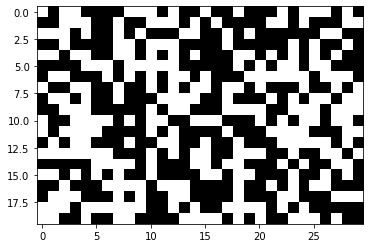

In [18]:
key, nkey = random.split(key)
img = random.bernoulli(nkey, shape = (20,30)).astype(jnp.float32)
plt.imshow(img, vmax=1, vmin=0,  cmap='gray');

Now we will build a transform function that averages the values on one axis. By averaging the 0s and 1s on each row of this above image, we will produce horizontal bands of different brightness.

I do this in two passes. The first vectorizes the *mean* processing the elements axis 0 (rows) to produce a single 1D column. The next expands this single column out to the width of the image.


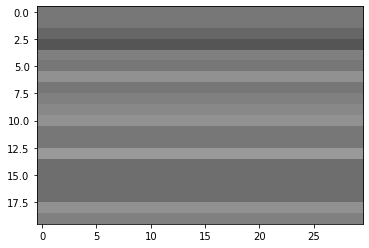

In [51]:
img = random.bernoulli(nkey, shape = (20,30)).astype(jnp.float32)

def mean(row):
    return jnp.mean(row)

def expand(pixel, width):
    return jnp.repeat(pixel, width)

column = vmap(mean)(img)
img = vmap(expand, in_axes=(0,None))(column, img.shape[1])
plt.imshow(img, vmax=1, vmin=0,  cmap='gray');

Notice in the *expand* vmap I passed the shape of the image as a constant to the vectorized function. When doing so, I had to explicitly tell vmap not to operate on the elements if *img.shape[1]* by using the optional *in_axes* argument...


    img = random.bernoulli(nkey, shape = (20,30)).astype(jnp.float32)

    column = vmap(mean)(img)
    img = vmap(expand, in_axes=(0,None))(column, img.shape[1])
    plt.imshow(img, vmax=1, vmin=0,  cmap='gray');

    >>> ValueError: vmap was requested to map its argument along axis 0, which implies that its
     rank should be at least 1, but is only 0 (its shape is ())


At first the above error had me in a total state of despair. I didn't know that the error was referring to the shape argument. Also, what is all this business about *rank*?

Now that I understand it, *in_axes* is actually quite intuitive. You need to supply a tuple with an element for each argument passed to the vectorized function. Each element is an integer axis or None. None means don't try to operate on the elements of the argument.

Here is a quick illustration:

Consider 2 images. One is 30x20 and the other 20x30.

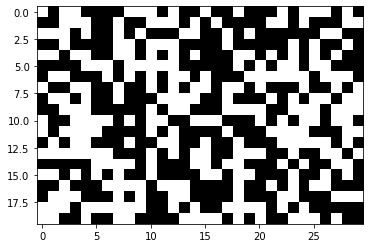

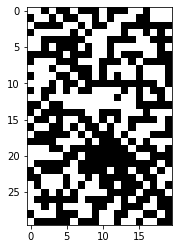

In [52]:
key,nkey2 = random.split(key)
img1 = random.bernoulli(nkey, shape = (20,30)).astype(jnp.float32)
img2 = random.bernoulli(nkey2, shape = (30,20)).astype(jnp.float32)
plt.imshow(img1, vmax=1, vmin=0,  cmap='gray');
plt.show()
plt.imshow(img2, vmax=1, vmin=0,  cmap='gray');

I want to average these two images and then make horizontal bands. If I neglect to describe what axes to use, look what happens:

    def mean(pixel1,pixel2):
        return pixel1 + pixel2 /2

    column = vmap(mean)(img1,img2)
    img = vmap(expand)(column, img.shape[1])
    plt.imshow(img, vmax=1, vmin=0,  cmap='gray');

    >>> ValueError: vmap got inconsistent sizes for array axes to be mapped:
    arg 0 has shape (20, 30) and axis 0 is to be mapped
    arg 1 has shape (30, 20) and axis 0 is to be mapped
    so
    arg 0 has an axis to be mapped of size 20
    arg 1 has an axis to be mapped of size 30


This error message is pretty detailed. It is obvious that my two images with different aspect ratios don't line up. If I were in an image editor, I would rotate the second image to match the first. With *in_axes* I don't need to do that as I can specify a different axis for each image. I want to traverse the rows of the first image and the columns of the second.

I can tell vmap to operate on  axis 1 (columns) of image2 as image 2 has the same number of columns as image 1 has rows (axis 0). *in_axes = (0,1)* is a clean way to express this.


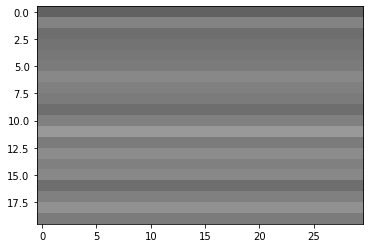

In [21]:
def mean(pixels1,pixels2):
    return (jnp.mean(pixels1) + jnp.mean(pixels2)) / 2

img1 = random.bernoulli(nkey, shape = (20,30)).astype(jnp.float32)
img2 = random.bernoulli(nkey2, shape = (30,20)).astype(jnp.float32)

column = vmap(mean, in_axes=(0,1))(img1,img2)
img = vmap(expand, in_axes=(0,None))(column,img1.shape[1])
plt.imshow(img, vmax=1, vmin=0,  cmap='gray');

If you are struggling to get productive with vmap, I hope by sharing some of my mis-adventures with random numbers; shapes of arrays and multiple arguments; it will help you get productive faster.